In [1]:
import torch
import numpy as np
from statistics import mean
import math
import random
from tqdm import tqdm
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
device = 'cpu'

def lock_seed(seed = 666):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

lock_seed()

Utils

In [2]:
def count_scroes(y_preds : np.array, targets : np.array):
    """
    Calculate metrics, listed below, for every classs and put them in a dict
    """
    scores_dict={}
    
    for i in np.unique(targets):

        tp = np.sum(
            np.logical_and(y_preds == i, targets == i)
            )
        tn = np.sum(
            np.logical_and(y_preds != i, targets != i)
            )
        fp = np.sum(
            np.logical_and(y_preds == i, targets != i)
            )
        fn = np.sum(
            np.logical_and(y_preds != i, targets == i)
            )

        precision = tp/(tp + fp)
        recall = tp/(tp + fn)
        accuracy = (tp + tn)/targets.shape[0]

        scores_dict[i] = {
            'Precision' : precision,
            'Recall' : recall,
            'Accuracy' : accuracy,
            }
        
    return scores_dict


def transform_data_for_ploting(dict : dict):
    """
    Transform dict.keys to list and dict.values to list to be able to plot data
    """
    lists = sorted(dict.items())
    x, y = zip(*lists)
    return x, y



Class to store metrics

In [3]:
from pandas.core.window.common import defaultdict
from dataclasses import dataclass
from typing import List

class MetricList:
    """
    Class that stores {target_parameter(you want to visualize) : [metric value]}
    for certain metric of certain class
    Easy to visualize
    """
    def __init__(self, n_class, metric_name):

      
      self.n_class = n_class
      self.metric_name = metric_name
      self.target_parameter2value = defaultdict(list)
      self.target_parameter2median = defaultdict(list)
      
    def append(self, target_parameter, metrics):
      self.target_parameter2value[target_parameter].append(metrics[self.n_class][self.metric_name])
      self.target_parameter2median[target_parameter] = mean(self.target_parameter2value[target_parameter])

Data Set

In [4]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data,
    wine.target,
    test_size=0.3,
    shuffle=True
)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

X_test = X_test.to(device)
y_test = y_test.to(device)

Model

In [5]:
class WineNet(nn.Module):

    def __init__(self, n_hidden_neurons):
        super().__init__()
        self.fc1 = nn.Linear(13, n_hidden_neurons)
        self.act1 = nn.Sigmoid()
        self.fc2 = nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.act2 = nn.Sigmoid()
        self.fc3 = nn.Linear(n_hidden_neurons, 3)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x
    
    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)

# wine_net = WineNet(10)


In [6]:
def train_model(epochs, batch_size, n_hidden_neurons):

    wine_net = WineNet(n_hidden_neurons).to(device)
    optimizer = torch.optim.Adam(wine_net.parameters(),
                            lr=0.001)
    loss = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = wine_net.forward(X_batch)

            loss_train = loss(preds, y_batch)
            loss_train.backward()

            optimizer.step()

        
    test_preds = wine_net.forward(X_test)
    test_preds = test_preds.argmax(dim=1)

    scores = count_scroes(test_preds.cpu().numpy(), y_test.cpu().numpy())
    return scores

Testing number of hidden neurons

In [7]:
"""Target parameter we want to test metrics on"""
n_hidden_neurons = np.arange(1, 21)


metric_class_init = False
for n in tqdm(n_hidden_neurons):
   
    batch_size = 10
    epochs = 2000

    for train_run in range(5):

        metrics = train_model(epochs, batch_size, n)
        for n_class in metrics:
            for metric_name in metrics[n_class]:
           
                if not metric_class_init:
                #  init dict of MetricList
                    metrics_dict_neurons = {n_class : {metric_name : MetricList(n_class,metric_name) for metric_name in metrics[n_class]} for n_class in metrics}
                    metric_class_init = True

                #  append new values after each training run
                metrics_dict_neurons[n_class][metric_name].append(n,metrics)


  0%|          | 0/20 [00:00<?, ?it/s]D:\Tmp\ipykernel_23060\637827620.py:22: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp + fp)
100%|██████████| 20/20 [26:14<00:00, 78.71s/it]


Plot Results

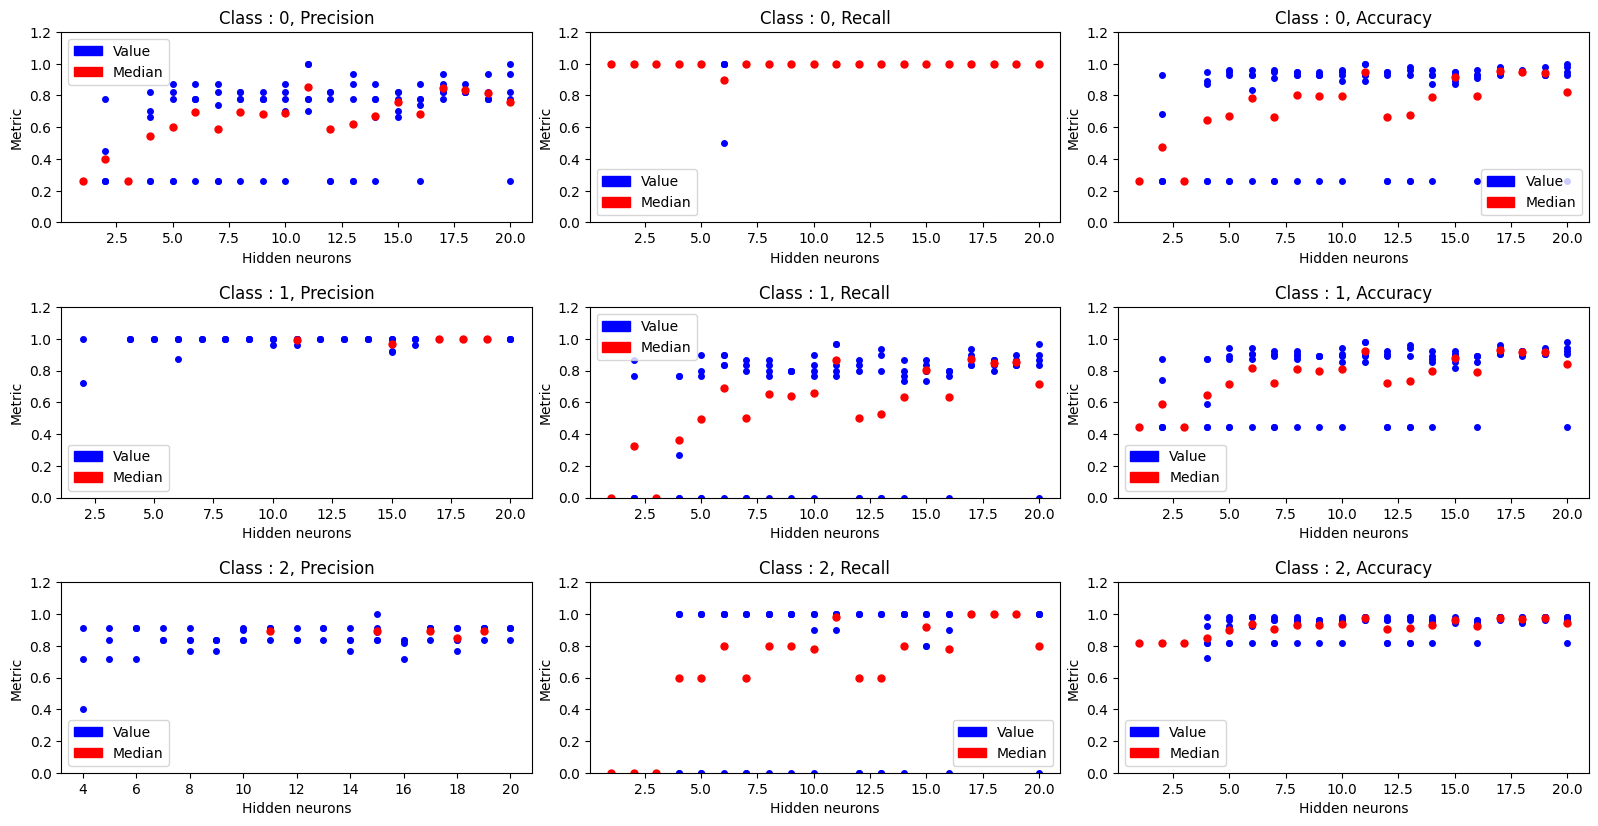

In [9]:

figure, axis = plt.subplots(3, 3)
figure.tight_layout(h_pad=4)


matplotlib.rcParams['figure.figsize'] = (16, 8)

for i, class_n in enumerate(metrics_dict_neurons):
        for j, metric_name in enumerate(metrics_dict_neurons[class_n]):
                data = metrics_dict_neurons[class_n][metric_name].target_parameter2value
                x, y = transform_data_for_ploting(data)
                value = axis[i, j].plot(x, y, 'bo', markersize=4, label="Value")

                data = metrics_dict_neurons[class_n][metric_name].target_parameter2median
                x, y = transform_data_for_ploting(data)
                median = axis[i, j].plot(x, y, 'ro', markersize=5, label="Median")

                axis[i, j].set_title(f"Class : {class_n}, {metric_name}")
                axis[i, j].set_xlabel('Hidden neurons')
                axis[i, j].set_ylabel('Metric')
                axis[i, j].set_ylim([0,1.2])

                value_patch = mpatches.Patch(color='blue', label="Value")
                median_patch = mpatches.Patch(color='red', label="Median")
                axis[i, j].legend(handles=[value_patch, median_patch])


plt.show()

        

Testing batch size

In [10]:
"""Target parameter we want to test metrics on"""
import time

batch_size2time = {}
n = 20

metric_class_init = False
for t in tqdm(range(1,9)):
   
    batch_size = 2 ** t
    epochs = 1


    start_time = time.time()
    train_model(epochs, batch_size, n)
    end_time = time.time()
    batch_size2time[batch_size] = end_time - start_time



  0%|          | 0/8 [00:00<?, ?it/s]D:\Tmp\ipykernel_23060\637827620.py:22: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp + fp)
100%|██████████| 8/8 [00:00<00:00, 93.00it/s]


Plot Results

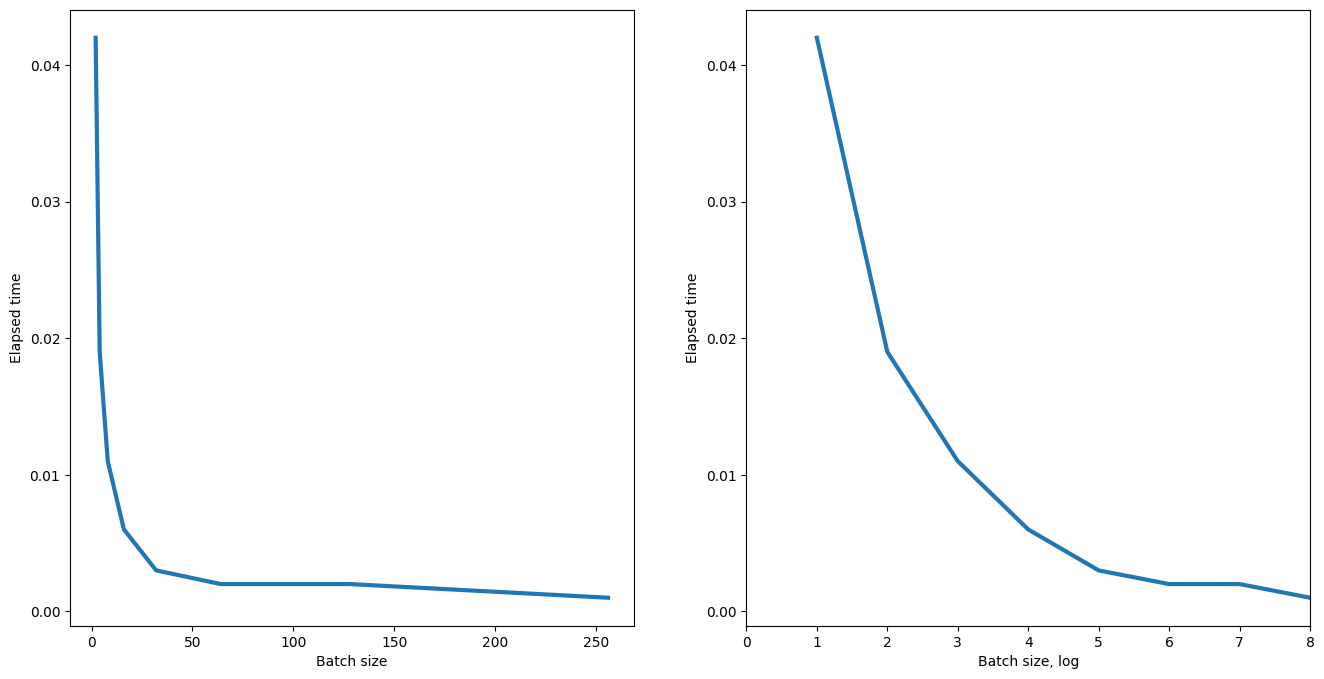

In [11]:
figure, axis = plt.subplots(1,2)

x, y = transform_data_for_ploting(batch_size2time)

axis[0].plot(x, y, linewidth=3)
axis[0].set_xlabel('Batch size')
axis[0].set_ylabel('Elapsed time')

axis[1].plot(np.log2(x), y, linewidth=3)
axis[1].set_xlabel('Batch size, log')
axis[1].set_ylabel('Elapsed time')
axis[1].set_xlim([0,8])

plt.show()

Testing train/test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    wine.data,
    wine.target,
    test_size=0.3,
    shuffle=True
)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [15]:
"""Target parameter we want to test metrics on"""



metric_class_init = False
for split_koef in tqdm(np.arange(0.1, 1, 0.1)):


    X_train, X_test, y_train, y_test = train_test_split(
                                                        wine.data,
                                                        wine.target,
                                                        test_size=split_koef,
                                                        shuffle=True
                                                        )
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train)
    y_test = torch.LongTensor(y_test)

    X_test = X_test.to(device)
    y_test = y_test.to(device)

   
    batch_size = 256
    epochs = 2000

    for train_run in range(5):

        metrics = train_model(epochs, batch_size, 10)
        for n_class in metrics:
            for metric_name in metrics[n_class]:
           
                if not metric_class_init:
                #  init dict of MetricList
                    metrics_dict_testsize = {n_class : {metric_name : MetricList(n_class,metric_name) for metric_name in metrics[n_class]} for n_class in metrics}
                    metric_class_init = True

                #  append new values after each training run
                metrics_dict_testsize[n_class][metric_name].append(split_koef,metrics)

  0%|          | 0/9 [00:00<?, ?it/s]D:\Tmp\ipykernel_24436\637827620.py:22: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp + fp)
100%|██████████| 9/9 [01:06<00:00,  7.42s/it]


Plot Results

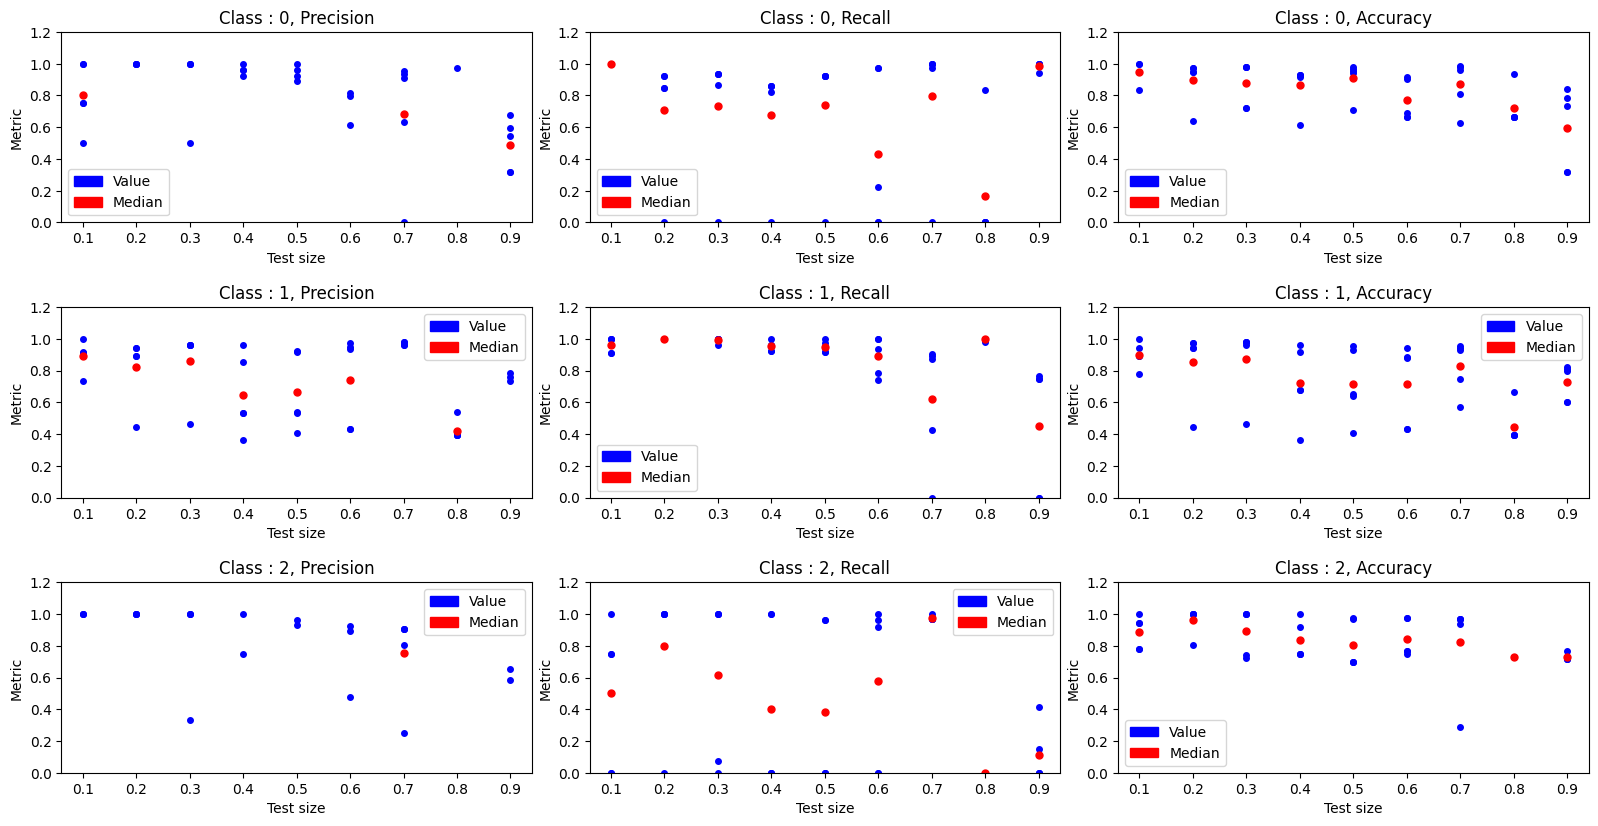

In [16]:
figure, axis = plt.subplots(3, 3)
figure.tight_layout(h_pad=4)


matplotlib.rcParams['figure.figsize'] = (16, 8)

for i, class_n in enumerate(metrics_dict_testsize):
        for j, metric_name in enumerate(metrics_dict_testsize[class_n]):
                data = metrics_dict_testsize[class_n][metric_name].target_parameter2value
                x, y = transform_data_for_ploting(data)
                axis[i, j].plot(x, y, 'bo', markersize=4)

                data = metrics_dict_testsize[class_n][metric_name].target_parameter2median
                x, y = transform_data_for_ploting(data)
                axis[i, j].plot(x, y, 'ro', markersize=5)

                axis[i, j].set_title(f"Class : {class_n}, {metric_name}")
                axis[i, j].set_xlabel('Test size')
                axis[i, j].set_ylabel('Metric')
                axis[i, j].set_ylim([0,1.2])

                value_patch = mpatches.Patch(color='blue', label="Value")
                median_patch = mpatches.Patch(color='red', label="Median")
                axis[i, j].legend(handles=[value_patch, median_patch])


plt.show()